In [1]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import requests
import configparser
from tqdm import tqdm_notebook
import seaborn as sns

from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

In [2]:
def make_query(area, radius):
    """
    For a given neighborhood, queries Yelp API for restaurants.
    Since each API pull only returns 50 results, break the queries up into chunks using the "offset" keyword.
                         
    params:
        area (str): neighborhood name (Yelp search term)
        radius (int): Yelp search radius in meters (i.e. radius of neighborhood)
    """
    query_number = 0
    num_failures = 0
    print(f'querying {area}...')
    results = client.execute(gql(generate_query(area, radius)))
    
    n_restaurants = results['search']['total']
    area_df = yelp_json_to_df(results)
    
    
    while len(area_df) < n_restaurants:
        if num_failures > 3:
            break
        query_number += 1
        try:
            subsequent_results = client.execute(gql(generate_query(area, radius, query_num=query_number)))
            subsequent_df = yelp_json_to_df(subsequent_results)
            area_df = area_df.append(subsequent_df)
        except Exception as e:
            print(f'ERROR on {area} query #{query_number}: {e}')
            num_failures += 1

    area_df.drop(columns=['coordinates', 'categories'], inplace=True)
    area_df.to_csv(f'../../data/pizza/raw/{area}_restaurants.csv', index=False)
    
    return area_df
    
def generate_query(area, radius, category='restaurants', query_num=0, limit=50):
    """
    Generates the Yelp API query string based on desired search terms.
    
    params:
        area (str): neighborhood name (Yelp search term)
        radius (int): Yelp search radius in meters (i.e. radius of neighborhood)
        category (str): category name (Yelp search term)
        query_num (int): Tracks how many requests have been made since only 50 results are returned at a time.
        limit (int): how many results to return. max is 50.
    """
    
    parameters = '''{
            total
                business {
                    name
                    url
                    rating
                    review_count
                    price
                    coordinates {
                        latitude
                        longitude
                    }
                    categories {
                        title
                        alias
                        parent_categories{
                            title
                            alias
                      }
                    }

                }
            }'''
    
    offset_results = f', offset: {query_num*50}' if query_num > 0 else ''
        
    
    search = f'search(categories: "{category}", location: "{area}, Manhattan, NY", radius:{radius}, limit: {limit}{offset_results})'
    return f'\u007b{search} {parameters}\u007d'

def yelp_json_to_df(results_dict):
    """
    Rearranges Yelp-returned json by splitting and coordinates collapsing category information into single values.
    """
    for business in results_dict['search']['business']:
        try:
            business['latitude'] = business['coordinates']['latitude']
            business['longitude'] = business['coordinates']['longitude']
        except TypeError:
            ## no coordinate data
            continue
        
        try:
            business['category'] = business['categories'][0]['alias']
        except IndexError:
            ## no category data
            continue
            
        try:
            business['parent_category'] = business['categories'][0]['parent_categories'][0]['alias']
        except IndexError:
            ## no parent category data
            continue    
    return pd.DataFrame(results_dict['search']['business'])

    

In [3]:

## Most pizzas period
def count_establishments(neighborhood_df, subset=None):
    if subset:
        return len(neighborhood_df.query('category == @subset'))
    else:
        return len(neighborhood_df)

## Most restaurants/pizza per area
def count_per_km2(neighborhood_df, area, subset='pizza'):
    if subset:
        return round(len(neighborhood_df.query('category == @subset')) / area, 1)
    else:
        return round(len(neighborhood_df) / area, 1)

## Highest average rating for pizza (minimum) 
def avg_rating(neighborhood_df, subset='pizza', weight=True):
    if subset:
        neighborhood_df = neighborhood_df.query('category == @subset').copy()

    if weight:
        weighted_rating = neighborhood_df['rating'] * neighborhood_df['review_count']
        return weighted_rating.sum() / neighborhood_df['review_count'].sum()
    else:
        return neighborhood_df['rating'].mean()
    
    ## highest rating * number reviews

##  most reviewed pizza
def count_reviews(neighborhood_df, subset='pizza', how='sum'):
    if subset:
        neighborhood_df = neighborhood_df.query('category == @subset').copy()
    return neighborhood_df['review_count'].agg(how)
    
## Pizza quotient
def food_quotient(city_df, categories_to_exclude=None):
    calculate_rank = lambda series: series.rank(method='max', ascending=False)
    
    if categories_to_exclude:
        city_df = city_df.query('~category.isin(@categories_to_exclude)')
    
    total_df = city_df.pivot_table(columns='neighborhood', index='category', values='name', 
                                    aggfunc='count', fill_value=0) \
                       .stack() \
                       .reset_index() \
                       .rename(columns={0:'count', 'category':'cuisine'})
    TOTAL_RESTAURANTS = total_df['count'].sum()
    total_df['cuisine_total'] = total_df['cuisine'].map(total_df.groupby('cuisine')['count'].sum())
    total_df['pct_of_cuisine'] = total_df['count'] / total_df['cuisine_total']

    total_df['neighborhood_total'] = total_df['neighborhood'].map(total_df.groupby('neighborhood')['count'].sum())

    total_df['pct_of_neighborhood'] = total_df['count'] / total_df['neighborhood_total']
    
    total_df['food_quotient'] = total_df['pct_of_neighborhood'] / (total_df['cuisine_total']/TOTAL_RESTAURANTS)
    total_df['food_quotient_rank'] = total_df.groupby('cuisine')['food_quotient'].apply(calculate_rank).values

    return total_df


### Load geojson shapefile

In [4]:
## originally downloaded from https://data.beta.nyc/dataset/pediacities-nyc-neighborhoods 
geo = gpd.read_file('../../data/pizza/nycneighborhoods.json')
geo = geo.to_crs(3857)

geo['area'] = geo['geometry'].area
geo['radius'] = (np.ceil(np.sqrt(geo['area']) / 2)).astype(int)

In [5]:
geo_manhattan = geo.query('borough == "Manhattan" and ~neighborhood.str.endswith("Island")').reset_index(drop=True)

In [6]:
nbhd_radii = geo_manhattan.set_index('neighborhood')['radius'].to_dict()
nbhd_areas = (geo_manhattan.set_index('neighborhood')['area']/10**6).to_dict()

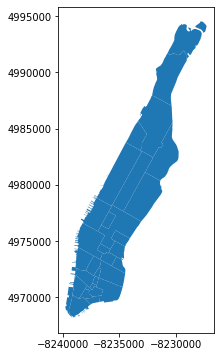

In [7]:
geo_manhattan.plot(figsize=(10,6))

### Make query for each neighborhood from Yelp

In [8]:
# from config import api_key

api_key = "gFh8ZZSJq-DFYtF-cLzYLfX-1Cb2t1djJDNdEKO3hHzhETzkjK2ku5mJxUBG828EJwOryqFz02eUH1_eYNfQduFdQzHltTPzyH4PLZkXVBbtfAL6rkvoWNU0B0-bXnYx"

# define our authentication process.
header = {'Authorization': 'bearer {}'.format(api_key),
          'Content-Type':"application/json"}

# Build the request framework
transport = RequestsHTTPTransport(url='https://api.yelp.com/v3/graphql', headers=header, use_json=True)

# Create the client
client = Client(transport=transport, fetch_schema_from_transport=True)

In [9]:
## categories to exclude -- not restaurants
EXCLUDE = ['bars', 'coffee', 'juicebars', 'desserts', 'bubbletea', 'icecream', 'coffeeroasteries', 
           'beveragestores', 'grocery', 'butcher', 'donuts', 'tea', 'pretzels', 'convenience', 'chimneycakes',
           'chocolate', 'venues', 'festivals', 'fooddeliveryservices', 'movietheaters', 'gelato', 'eventplanning',
           'musicvenues', 'arcades', 'bookstores', 'culturalcenter', 'popupshops', 'sports_clubs', 'tobaccoshops']

In [10]:
PARENT_EXCLUDE = ['bars', 'nightlife', 'beautysvc', 'active', 'localservices']

In [11]:
## make queries; add clause so we first check if data is already saved
all_df = {}
for area in tqdm_notebook(nbhd_radii):
    try:
        df = pd.read_csv(f'../../data/pizza/raw/{area}_restaurants.csv')
    except FileNotFoundError:
        df = make_query(area, radius=nbhd_radii[area])
        
    df.insert(0, 'neighborhood', area)
    df = df.query('~category.isin(@EXCLUDE) and ~parent_category.isin(@PARENT_EXCLUDE)').copy()
    all_df[area] = df

yelp_nyc = pd.concat(list(all_df.values())).reset_index(drop=True)
yelp_nyc.to_csv('../../data/pizza/yelp_results_all.csv', index=False)

### Generate summary data

In [12]:
category_size = yelp_nyc['category'].value_counts()
cuisine_df = food_quotient(yelp_nyc, categories_to_exclude=list(category_size[category_size <= 5].index))

In [13]:
neighborhood_df = []
for nbhd, nbhd_df in yelp_nyc.groupby('neighborhood'):
    area = nbhd_areas.get(nbhd)
    row = {'neighborhood': nbhd, 'area': area,
           'n_restaurant': count_establishments(nbhd_df, subset=None),
           'n_pizzeria': count_establishments(nbhd_df, subset='pizza'),
           'n_restaurant_per_km2': count_per_km2(nbhd_df, area, subset=None),
           'n_pizzeria_per_km2': count_per_km2(nbhd_df, area, subset='pizza'),
           'rating_restaurant': avg_rating(nbhd_df, subset=None, weight=True),
           'rating_pizzeria': avg_rating(nbhd_df, subset='pizza', weight=True),
           'rating_pizzeria_unweighted': avg_rating(nbhd_df, subset='pizza', weight=False),
           'total_reviews_restaurant': count_reviews(nbhd_df, subset=None),
           'median_reviews_restaurant': count_reviews(nbhd_df, subset=None, how='median'),
           'median_reviews_pizzeria': count_reviews(nbhd_df, subset='pizza', how='median')}
    row['pizzeria_pct_of_nbhd'] = row['n_pizzeria'] / row['n_restaurant']
    row['pizzeria_pct_of_nbhd'] = row['n_pizzeria'] / row['n_restaurant']
    neighborhood_df.append(row)

neighborhood_df = pd.DataFrame(neighborhood_df)

/Users/aaronlee/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


In [14]:
neighborhood_df['pizzeria_pct_delta'] = neighborhood_df['pizzeria_pct_of_nbhd'] - neighborhood_df['pizzeria_pct_of_nbhd'].mean()
quotient_stats = ['cuisine', 'pct_of_cuisine', 'pct_of_neighborhood', 'food_quotient']
top_cuisine = cuisine_df.sort_values('food_quotient', ascending=False) \
                        .query('count >= 5') \
                        .groupby('neighborhood')[quotient_stats].first().to_dict()

for col in quotient_stats:
    neighborhood_df['top_'+col] = neighborhood_df['neighborhood'].map(top_cuisine[col])

In [15]:
cuisine_df.sort_values('food_quotient', ascending=False) \
          .query('count >= 5') \
          .groupby('neighborhood') \
          .apply(lambda df: df['cuisine'].head(3).values)

neighborhood
Battery Park City            [french, mexican, newamerican]
Central Park              [breakfast_brunch, french, cafes]
Chelsea                        [spanish, foodstands, halal]
Chinatown                 [cantonese, shanghainese, dimsum]
East Harlem               [chicken_wings, caribbean, latin]
East Village                [vietnamese, mideastern, vegan]
Financial District          [foodtrucks, foodstands, greek]
Flatiron District            [italian, sandwiches, mexican]
Gramercy               [chinese, tradamerican, newamerican]
Greenwich Village            [french, newamerican, mexican]
Harlem                 [caribbean, southern, chicken_wings]
Hell's Kitchen                  [mideastern, thai, burgers]
Inwood                          [dominican, latin, seafood]
Kips Bay                            [cafes, sushi, chinese]
Little Italy                             [italian, chinese]
Lower East Side                    [ramen, bakeries, pizza]
Midtown                    

### Export data

In [16]:

geo_to_exclude = ['Central Park', 'Marble Hill']
neighborhood_df.query('~neighborhood.isin(@geo_to_exclude)').to_csv('../../data/pizza/neighborhood_summary.csv', index=False)
cuisine_df.query('count > 5').to_csv('../../data/pizza/cuisine_quotient.csv', index=False)


### Explorations

Neighborhoods where pizzerias form the largest proportion of all restaurants

In [17]:
neighborhood_df.query('n_pizzeria > 5').sort_values('pizzeria_pct_of_nbhd')

,neighborhood,area,n_restaurant,n_pizzeria,n_restaurant_per_km2,n_pizzeria_per_km2,rating_restaurant,rating_pizzeria,rating_pizzeria_unweighted,total_reviews_restaurant,median_reviews_restaurant,median_reviews_pizzeria,pizzeria_pct_of_nbhd,pizzeria_pct_delta,top_cuisine,top_pct_of_cuisine,top_pct_of_neighborhood,top_food_quotient
23,SoHo,1.591154,210,7,132.0,4.4,3.860720,3.794384,3.928571,72171,158.5,314.0,0.033333,-0.043583,french,0.087302,0.053398,2.766528
10,Greenwich Village,1.312864,138,7,105.1,5.3,3.876845,3.625000,3.357143,46949,166.5,113.0,0.050725,-0.026191,french,0.047619,0.044444,2.302646
20,Murray Hill,1.210703,148,8,122.2,6.6,3.738515,3.264041,3.187500,31933,120.5,129.0,0.054054,-0.022862,bagels,0.100000,0.034014,4.440816
18,Midtown,6.200554,864,57,139.3,9.2,3.769458,3.754885,3.631579,312657,178.5,150.0,0.065972,-0.010944,korean,0.572816,0.069575,4.409599
2,Chelsea,4.763527,482,33,101.2,6.9,3.740218,3.747351,3.363636,97497,74.0,82.0,0.068465,-0.008451,spanish,0.243902,0.021413,3.409411
9,Gramercy,1.022449,102,7,99.8,6.8,3.659913,3.817487,3.357143,26083,100.5,109.0,0.068627,-0.008289,chinese,0.032164,0.110000,2.099649
7,Financial District,2.207170,358,26,162.2,11.8,3.775842,3.738882,3.576923,40476,49.5,104.0,0.072626,-0.004290,foodtrucks,0.333333,0.095101,6.270893
26,Tribeca,1.604703,182,14,113.4,8.7,3.738247,3.584921,3.142857,31948,69.5,34.0,0.076923,0.000007,tradamerican,0.054348,0.055866,1.982026
31,West Village,2.320521,349,27,150.4,11.6,3.881178,3.982782,3.796296,119860,176.0,51.0,0.077364,0.000448,french,0.126984,0.047337,2.452522
1,Central Park,6.232085,90,7,14.4,1.1,3.630806,3.453010,3.357143,14598,97.5,72.0,0.077778,0.000862,breakfast_brunch,0.040000,0.056818,2.967273


Each neighborhood's most concentrated cuisine

In [18]:
cuisine_df.sort_values('food_quotient').groupby('neighborhood').last()

,cuisine,count,cuisine_total,pct_of_cuisine,neighborhood_total,pct_of_neighborhood,food_quotient,food_quotient_rank
neighborhood,,,,,,,,
Battery Park City,creperies,1,11,0.090909,42,0.023810,14.129870,1.0
Central Park,catering,1,6,0.166667,88,0.011364,12.363636,1.0
Chelsea,peruvian,3,11,0.272727,467,0.006424,3.812342,1.0
Chinatown,cantonese,9,15,0.600000,248,0.036290,15.793548,1.0
Civic Center,tacos,1,30,0.033333,16,0.062500,13.600000,1.0
East Harlem,senegalese,3,6,0.500000,234,0.012821,13.948718,1.0
East Village,izakaya,3,7,0.428571,442,0.006787,6.329670,2.0
Financial District,waffles,2,6,0.333333,347,0.005764,6.270893,1.0
Flatiron District,cambodian,1,6,0.166667,100,0.010000,10.880000,1.0


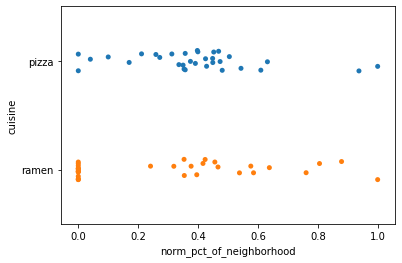

In [19]:
## distribution of ramen vs pizzeria: is one "rarer" than the other?
cuisine_df['norm_pct_of_neighborhood'] = cuisine_df.groupby('cuisine')['pct_of_neighborhood'].apply(lambda series: (series - series.min()) / series.max())
sns.stripplot(x="norm_pct_of_neighborhood", y="cuisine", data=cuisine_df.query('cuisine.isin(["pizza", "ramen"])'))